## GeoAI Ground-level NO2 Estimation Challenge by ITU

### Author: Hubert Kłosowski 242424

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Load data

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6576 entries, 0 to 6575
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            6576 non-null   object 
 1   Date                6576 non-null   object 
 2   ID                  6576 non-null   object 
 3   LAT                 6576 non-null   float64
 4   LON                 6576 non-null   float64
 5   Precipitation       6576 non-null   float64
 6   LST                 3595 non-null   float64
 7   AAI                 5708 non-null   float64
 8   CloudFraction       5708 non-null   float64
 9   NO2_strat           5708 non-null   float64
 10  NO2_total           5708 non-null   float64
 11  NO2_trop            3998 non-null   float64
 12  TropopausePressure  5708 non-null   float64
dtypes: float64(10), object(3)
memory usage: 668.0+ KB


### Extract date info

In [5]:
def extract_date_info(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='mixed')
    dataframe['DayOfWeek'] = dataframe['Date'].dt.dayofweek.astype('category')
    dataframe['Month'] = dataframe['Date'].dt.month.astype('category')
    dataframe['Year'] = dataframe['Date'].dt.year.astype('category')
    dataframe['Week'] = dataframe['Date'].dt.isocalendar().week.astype('category')
    dataframe.drop(['Date'], axis=1, inplace=True)
    return dataframe

train = extract_date_info(train)
test = extract_date_info(test)

### Target values in day of week

<Axes: xlabel='DayOfWeek', ylabel='GT_NO2'>

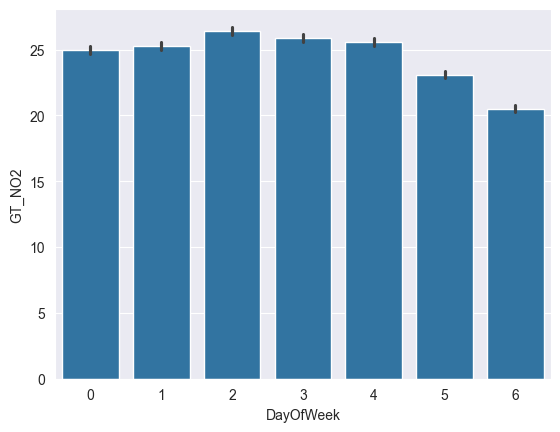

In [6]:
sns.barplot(data=train, x='DayOfWeek', y='GT_NO2')

### Target values in months

<Axes: xlabel='Month', ylabel='GT_NO2'>

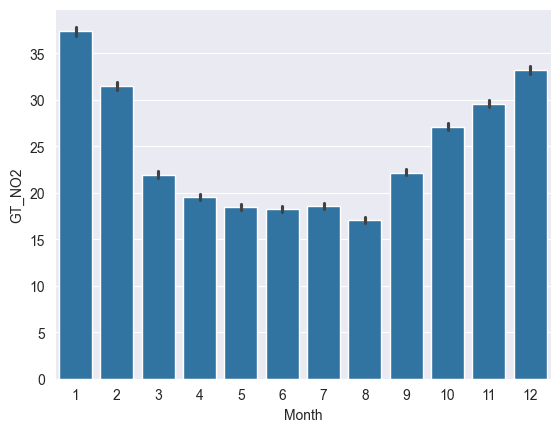

In [7]:
sns.barplot(data=train, x='Month', y='GT_NO2')

### Target values in years

<Axes: xlabel='Year', ylabel='GT_NO2'>

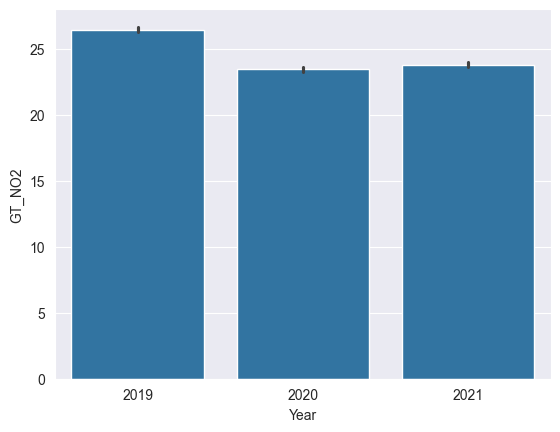

In [8]:
sns.barplot(data=train, x='Year', y='GT_NO2')

### Target values in weeks

<Axes: xlabel='Week', ylabel='GT_NO2'>

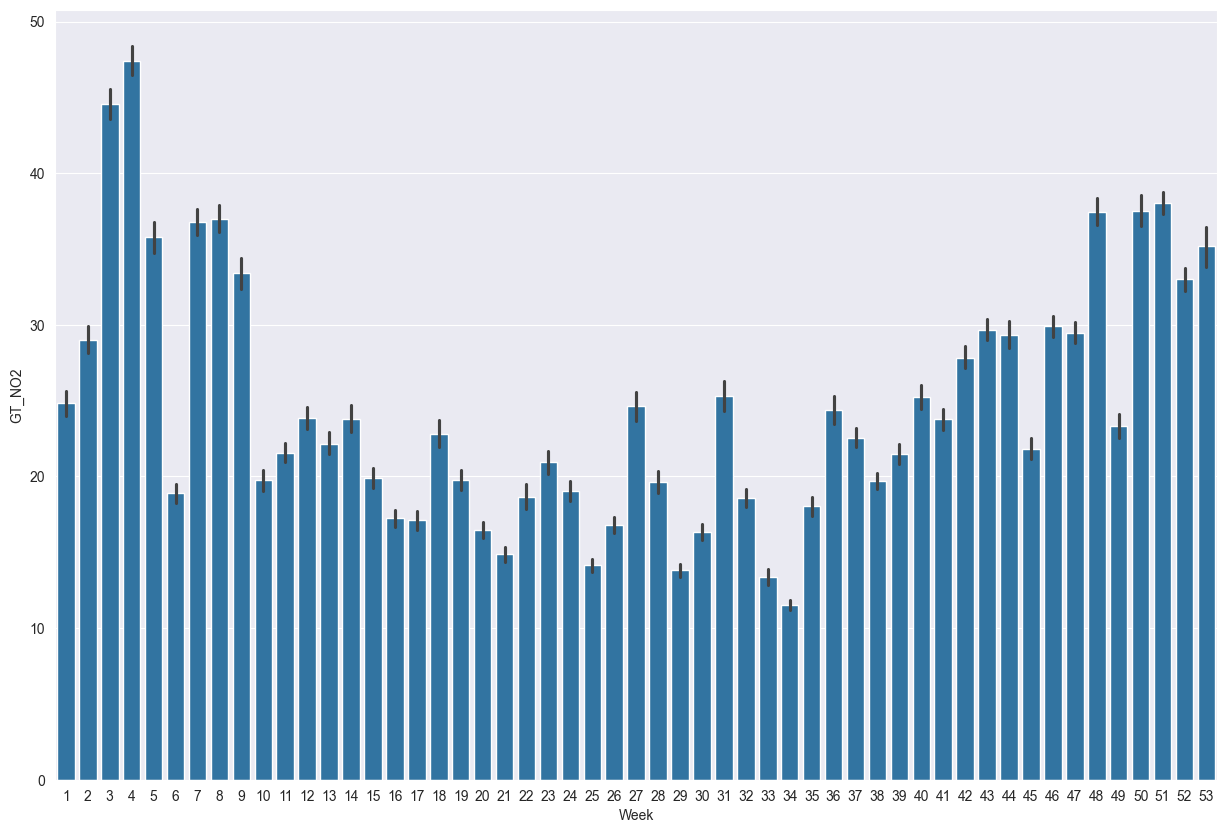

In [9]:
plt.figure(figsize=(15, 10))
sns.barplot(data=train, x='Week', y='GT_NO2')

### Map of id's in train dataset

In [10]:
import folium


my_map = folium.Map(
    location=(train['LAT'].mean(), train['LON'].mean()),
    zoom_start=7,
)

### Train Locations

In [11]:
unique_train_locations = train.groupby(['LAT', 'LON'])['GT_NO2'].mean().reset_index()
nans = train.loc[train['GT_NO2'].isna() == True, ['LAT', 'LON']].value_counts().to_frame().reset_index()
unique_train_locations = pd.merge(unique_train_locations, nans, on=['LAT', 'LON'], how='outer')
unique_train_locations.rename({'count': 'Nans'}, axis=1, inplace=True)
unique_train_locations['Nans'] = unique_train_locations['Nans'].apply(lambda x: round(x / 10.96, 2))

In [12]:
unique_train_locations

,LAT,LON,GT_NO2,Nans
0,44.924694,10.517502,19.853432,2.74
1,44.999546,9.008437,19.760846,1.64
2,45.016878,11.076095,15.886915,2.55
3,45.038758,11.790152,19.226606,0.55
4,45.040077,8.914145,16.350097,6.11
...,...,...,...,...
74,45.716300,10.044766,15.977089,4.29
75,45.730837,9.125734,21.815669,0.91
76,45.759273,11.735852,17.523721,1.92
77,45.842207,9.351658,18.330666,1.64


In [13]:
layer_train_map = folium.FeatureGroup(name='Train Locations', show=False)
for index, row in unique_train_locations.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; font-size: 14px;">
        <strong>Mean GT_NO2 level:</strong> {row["GT_NO2"]:.2f}<br>
        <strong>Latitude:</strong> {row["LAT"]}<br>
        <strong>Longitude:</strong> {row["LON"]}<br>
        <strong>Percent of nans:</strong> {row['Nans']} %
    </div>
    """
    popup = folium.Popup(popup_html, max_width=300)
    if row['Nans'] > 10:
        folium.Marker(
            location=[row['LAT'], row['LON']],
            icon=folium.Icon(color='green', icon_color='black', icon='home'),
            popup=popup,
        ).add_to(layer_train_map)
    else:
        folium.Marker(
            location=[row['LAT'], row['LON']],
            icon=folium.Icon(color='green', icon='home'),
            popup=popup,
        ).add_to(layer_train_map)
    
layer_train_map.add_to(my_map)

### Test Locations

In [14]:
unique_test_locations = test[['LAT', 'LON']].drop_duplicates()

layer_test_map = folium.FeatureGroup(name='Test Locations', show=False)
for index, row in unique_test_locations.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; font-size: 14px;">
        <strong>Latitude:</strong> {row["LAT"]}<br>
        <strong>Longitude:</strong> {row["LON"]}
    </div>
    """
    popup = folium.Popup(popup_html, max_width=300)
    folium.Marker(
        location=[row['LAT'], row['LON']],
        icon=folium.Icon(color='red', icon='home'),
        popup=popup,
    ).add_to(layer_test_map)
    
layer_test_map.add_to(my_map)

In [15]:
folium.LayerControl().add_to(my_map)
my_map.save('my_map.html')

### Prepare data

In [16]:
test_ids = test['ID_Zindi']
train.reset_index(drop=True, inplace=True)
train.drop(columns=['ID', 'ID_Zindi'], axis=1, inplace=True)
test.drop(columns=['ID', 'ID_Zindi'], axis=1, inplace=True)

### Fill NO2_trop with diff between NO2_total and NO2_strat

In [17]:
# train_random_num = np.random.uniform(-1e-6, 1e-6, size=len(train))
# test_random_num = np.random.uniform(-1e-6, 1e-6, size=len(test))
# train.fillna({'NO2_trop': train['NO2_total'] - train['NO2_strat'] + train_random_num}, inplace=True)
# test.fillna({'NO2_trop': test['NO2_total'] - test['NO2_strat'] + test_random_num}, inplace=True)

### Correlation Matrix for train

<Axes: >

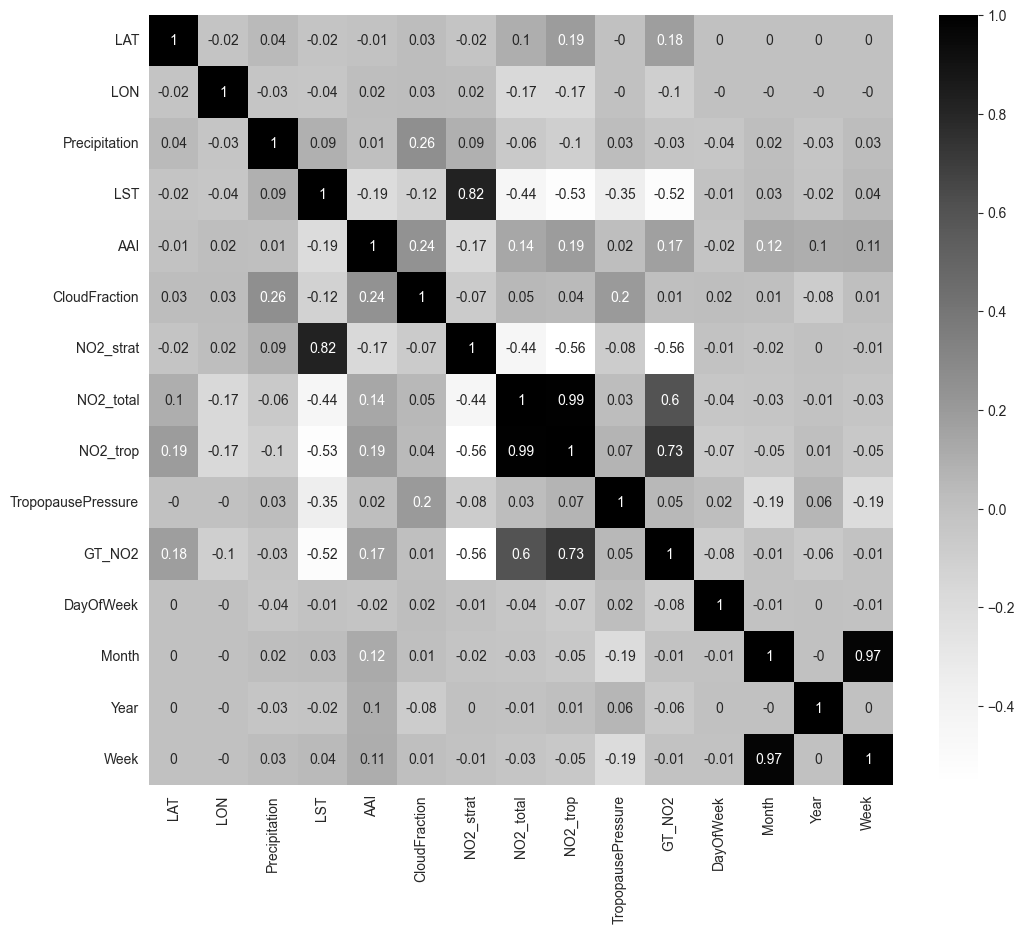

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr().round(2), annot=True, cmap='Greys')

### Correlation Matrix for test

<Axes: >

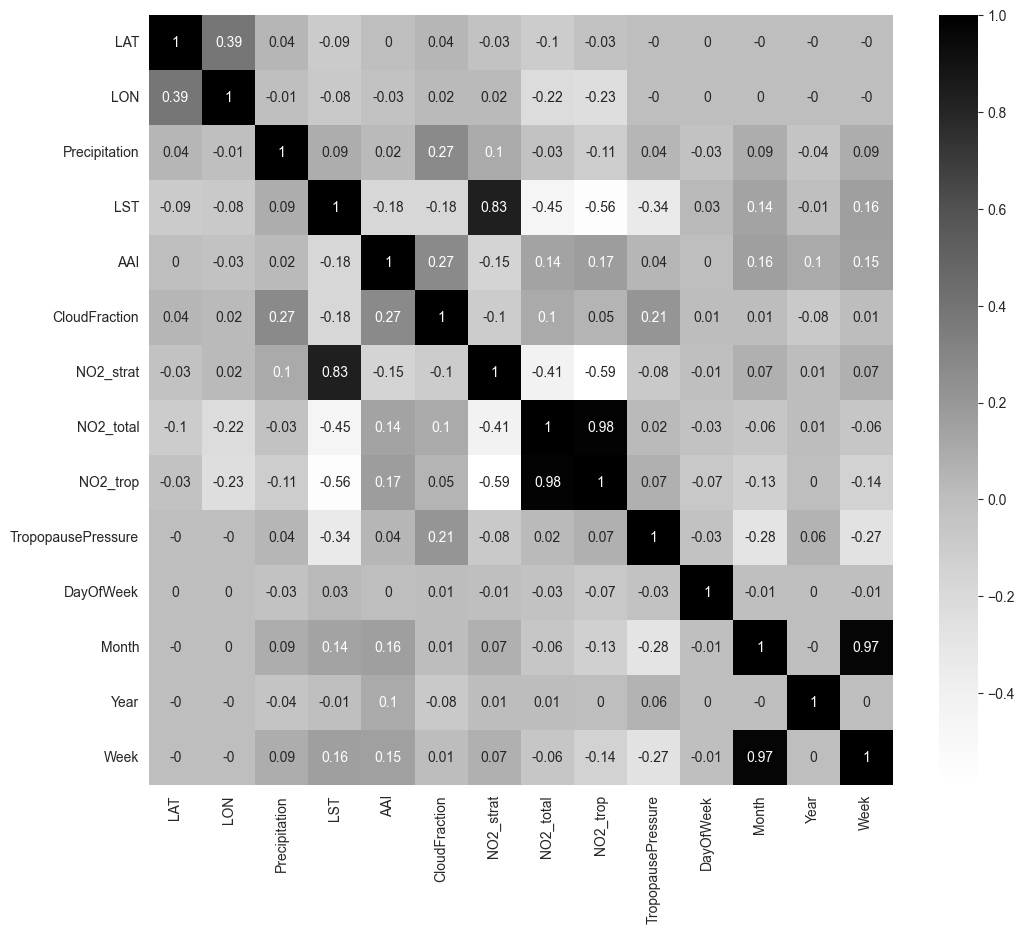

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(test.corr().round(2), annot=True, cmap='Greys')

### Scatter plots of columns from original dataset

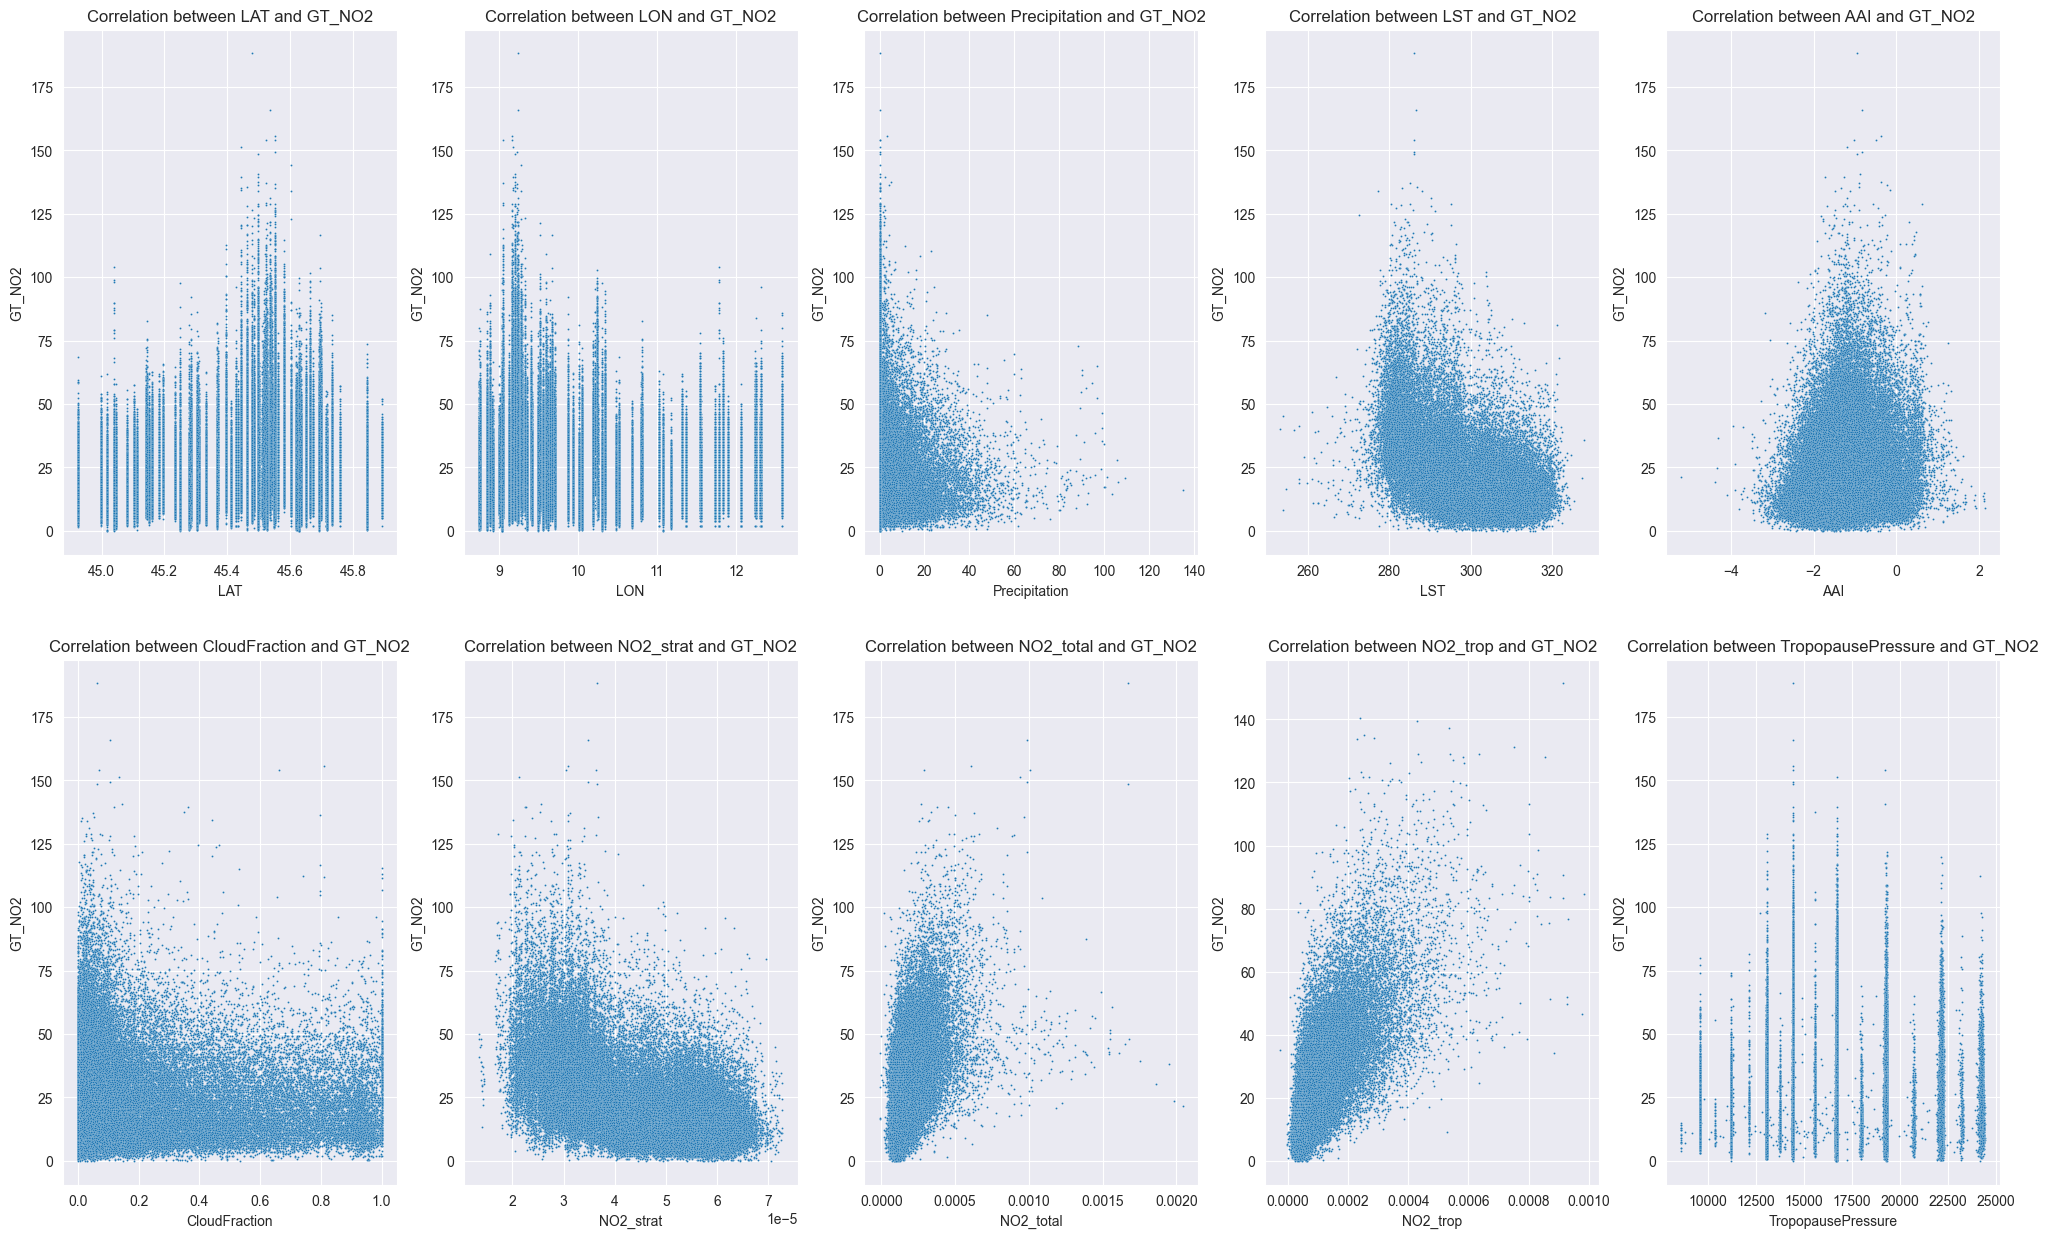

In [20]:
def plot_scatter():
    columns = [col for col in train.columns][:10]
    fig, ax = plt.subplots(nrows=len(columns) // 5, ncols=5, figsize=(25, 15))
    for i, col in enumerate(columns):
        x_cord, y_cord = divmod(i, 5)
        sns.scatterplot(data=train, x=col, y='GT_NO2', ax=ax[x_cord, y_cord], s=2)
        ax[x_cord, y_cord].set_title(f'Correlation between {col} and GT_NO2')
        ax[x_cord, y_cord].set_xlabel(col)
        ax[x_cord, y_cord].set_ylabel('GT_NO2')


plot_scatter()

### Do sth with NaNs in GT_NO2

train lightgbm to fill NaNs in train df
filled rows use for final training, or drop

In [21]:
train.dropna(subset=['GT_NO2'], inplace=True)

### Distribution of values

<Axes: ylabel='Frequency'>

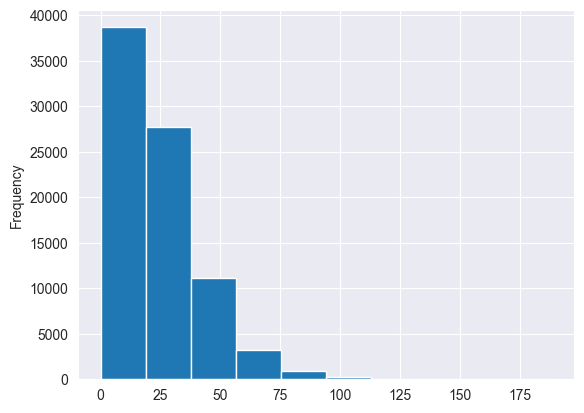

In [22]:
train['GT_NO2'].plot(kind='hist')

### Identify outliers in target column using zscore

In [23]:
from scipy.stats import zscore


detect_outliers = zscore(train['GT_NO2'])

upper_quantiles = pd.DataFrame(list(zip(np.linspace(0.98, 1, 21), [np.quantile(detect_outliers, el) for el in np.linspace(0.98, 1, 21)], [np.quantile(train['GT_NO2'], el) for el in np.linspace(0.98, 1, 21)])), columns=['quantile', 'zscore', 'GT_NO2'])

upper_quantiles

,quantile,zscore,GT_NO2
0,0.980,2.724629,71.150000
1,0.981,2.768466,71.900000
2,0.982,2.821071,72.800000
3,0.983,2.868050,73.603750
4,0.984,2.919266,74.480000
5,0.985,2.977424,75.475000
6,0.986,3.036312,76.482500
7,0.987,3.099218,77.558750
8,0.988,3.170892,78.785000
9,0.989,3.238986,79.950000


In [24]:
lower_quantiles = pd.DataFrame(list(zip(np.linspace(0.0, 0.1, 21), [np.quantile(detect_outliers, el) for el in np.linspace(0.0, 0.1, 21)], [np.quantile(train['GT_NO2'], el) for el in np.linspace(0.0, 0.1, 21)])), columns=['quantile', 'zscore', 'GT_NO2'])

lower_quantiles

,quantile,zscore,GT_NO2
0,0.000,-1.434066,0.000
1,0.005,-1.309860,2.125
2,0.010,-1.247027,3.200
3,0.015,-1.210496,3.825
4,0.020,-1.185655,4.250
5,0.025,-1.159352,4.700
6,0.030,-1.141817,5.000
7,0.035,-1.127205,5.250
8,0.040,-1.109670,5.550
9,0.045,-1.095058,5.800


### Deleting outliers in top 1.4% percentile

In [25]:
def del_gt_no2_outliers():
    train.reset_index(drop=True, inplace=True)
    indexes_to_drop = []
    q1, q2 = np.quantile(detect_outliers, 0.05), np.quantile(detect_outliers, 0.99)
    for i, el in enumerate(detect_outliers):
        if el > q2:
            indexes_to_drop.append(i)
    train.drop(indexes_to_drop, inplace=True)
    train.reset_index(drop=True, inplace=True)


del_gt_no2_outliers()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81231 entries, 0 to 81230
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LAT                 81231 non-null  float64 
 1   LON                 81231 non-null  float64 
 2   Precipitation       81231 non-null  float64 
 3   LST                 44021 non-null  float64 
 4   AAI                 69269 non-null  float64 
 5   CloudFraction       69269 non-null  float64 
 6   NO2_strat           69269 non-null  float64 
 7   NO2_total           69269 non-null  float64 
 8   NO2_trop            48123 non-null  float64 
 9   TropopausePressure  69269 non-null  float64 
 10  GT_NO2              81231 non-null  float64 
 11  DayOfWeek           81231 non-null  category
 12  Month               81231 non-null  category
 13  Year                81231 non-null  category
 14  Week                81231 non-null  category
dtypes: category(4), float64(11)
memory u

### Get elevation from LAT, LON

In [26]:
import requests
import pandas as pd

def get_elevation(lat, lon):
    query = f'https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}'
    r = requests.get(query).json()
    return r['results'][0]['elevation']


# unique_train_locations['Elevation'] = unique_train_locations.apply(lambda r: get_elevation(r['LAT'], r['LON']), axis=1)
# unique_test_locations['Elevation'] = unique_test_locations.apply(lambda r: get_elevation(r['LAT'], r['LON']), axis=1)
# unique_train_locations.drop(columns=['Nans', 'GT_NO2'], inplace=True)
# 
# train = train.merge(unique_train_locations, on=['LAT', 'LON'], how='left')
# test = test.merge(unique_test_locations, on=['LAT', 'LON'], how='left')

### Training process

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X, y = train.drop(columns=['GT_NO2'], axis=1), train['GT_NO2']

# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=scaler.feature_names_in_)
# test = pd.DataFrame(scaler.transform(test), columns=scaler.feature_names_in_)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [29]:
import lightgbm as lgb
import optuna
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, GroupKFold

### LightGBM

In [30]:
def define_lightgbm_model(trial):
    params = {
        'max_bin': trial.suggest_int('max_bin', 70, 250),
        'num_leaves': trial.suggest_int('num_leaves', 150, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 400, 700),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 400),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1, log=True),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'objective': 'root_mean_squared_error',
        'boosting_type': 'gbdt',
        'tree_learner': 'voting',
        'device': 'cpu',
        'n_jobs': -1,
        'random_state': 4,
        'verbosity': -1,
    }
    return lgb.LGBMRegressor(**params)

def objective_lightgbm(trial):
    model = define_lightgbm_model(trial)
    gkf = GroupKFold(n_splits=X['DayOfWeek'].nunique())
    scores = cross_val_score(model, X, y, groups=X['DayOfWeek'], cv=gkf, n_jobs=-1, scoring='neg_root_mean_squared_error')
    return scores.mean() * (-1)

### LightGBM study

In [ ]:
study_lightgbm = optuna.create_study(direction='minimize', study_name='GeoAIWithLightGBM', sampler=optuna.samplers.TPESampler())
study_lightgbm.optimize(objective_lightgbm, n_trials=200)

### LightGBM tylko dla najbliższych danych

In [ ]:
# limit_train = pd.read_csv(os.path.join('data', 'train.csv'))
# limit_test = pd.read_csv(os.path.join('data', 'test.csv'))
# 
# limit_train = extract_date_info(limit_train)
# limit_test = extract_date_info(limit_test)
# 
# limit_train.reset_index(drop=True, inplace=True)
# limit_train.drop(columns=['ID', 'ID_Zindi'], axis=1, inplace=True)
# limit_test.drop(columns=['ID', 'ID_Zindi'], axis=1, inplace=True)
# 
# train.dropna(subset=['GT_NO2'], inplace=True)
# 
# limit_X, limit_y = train.drop(columns=['GT_NO2'], axis=1), train['GT_NO2']
# 
# def objective_lightgbm_for_limit_data(trial):
#     model = define_lightgbm_model(trial)
#     gkf = GroupKFold(n_splits=X['DayOfWeek'].nunique())
#     scores = cross_val_score(model, limit_X, limit_y, groups=X['DayOfWeek'], cv=gkf, n_jobs=-1, scoring='neg_root_mean_squared_error')
#     return scores.mean() * (-1)
# 
# study_lightgbm = optuna.create_study(direction='minimize', study_name='GeoAIWithLightGBM', sampler=optuna.samplers.TPESampler())
# study_lightgbm.optimize(objective_lightgbm_for_limit_data, n_trials=200)

### Narazie najlepszy model ever

In [ ]:
# best_params =  {'max_bin': 157, 'num_leaves': 284, 'max_depth': 12, 'learning_rate': 0.018943556979846253, 'n_estimators': 658, 'bagging_fraction': 0.9910723110875617, 'colsample_bytree': 0.4051901668168799, 'min_data_in_leaf': 54, 'reg_lambda': 0.047054010015969996, 'bagging_freq': 3, 'device': 'cpu', 'n_jobs': -1, 'random_state': 4, 'verbosity': -1, 'tree_learner': 'voting', 'objective': 'root_mean_squared_error', 'boosting_type': 'gbdt'}
# 
# lgb_model = lgb.LGBMRegressor(**best_params)
# lgb_model.fit(X, y)

In [ ]:
lgb_model = define_lightgbm_model(study_lightgbm.best_trial)
lgb_model.fit(X, y)

In [ ]:
lightgbm_params = ['max_bin', 'num_leaves', 'max_depth', 'learning_rate', 'n_estimators', 'bagging_fraction', 'colsample_bytree', 'min_data_in_leaf']
lgb_pred = lgb_model.predict(X_test)
root_mean_squared_error(y_test, lgb_pred)

In [ ]:
from sklearn.model_selection import LearningCurveDisplay


LearningCurveDisplay.from_estimator(lgb_model, X, y, cv=GroupKFold(n_splits=X['DayOfWeek'].nunique()), groups=X['DayOfWeek'], n_jobs=-1, random_state=4, scoring='neg_root_mean_squared_error')

In [ ]:
# from sklearn.model_selection import LearningCurveDisplay
# 
# 
# LearningCurveDisplay.from_estimator(lgb_model, limit_X, limit_y, cv=GroupKFold(n_splits=X['DayOfWeek'].nunique()), groups=X['DayOfWeek'], n_jobs=-1, random_state=4, scoring='neg_root_mean_squared_error')

### Best params

In [ ]:
study_lightgbm.best_params

In [ ]:
def save_to_csv(y_pred, save_as):
    if 'result' not in os.listdir(os.getcwd()):
        os.mkdir('result')
    final_df = pd.concat([test_ids, pd.DataFrame.from_dict({'GT_NO2': y_pred})], axis=1)
    final_df.to_csv(os.path.join('result', save_as), index=False)
    
save_to_csv(lgb_model.predict(test), 'lightgbm.csv')

In [35]:
xd = pd.read_csv(os.path.join('result', 'lightgbm.csv'), header=0)
xd['GT_NO2'] *= 0.99
xd.to_csv(os.path.join('result', 'lightgbm_even_better.csv'), index=False)